In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    StandardScaler,
)

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_CATEGORIZADOS, DADOS_TRATADOS
from src.graficos import plot_coeficientes, plot_residuos

sns.set_theme(palette="bright")

RANDOM_STATE = 42

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,idade,sexo,imc,pressao_media,colesterol_total,ldl,hdl,colesterol_hdl,triglicerides,glicose,target
0,59,2,32.099998,101.0,157,93.199997,38.0,4.0,4.8598,87,151
1,48,1,21.600000,87.0,183,103.199997,70.0,3.0,3.8918,69,75
2,72,2,30.500000,93.0,156,93.599998,41.0,4.0,4.6728,85,141
3,24,1,25.299999,84.0,198,131.399994,40.0,5.0,4.8903,89,206
4,50,1,23.000000,101.0,192,125.400002,52.0,4.0,4.2905,80,135


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   idade             442 non-null    int8   
 1   sexo              442 non-null    int8   
 2   imc               442 non-null    float32
 3   pressao_media     442 non-null    float32
 4   colesterol_total  442 non-null    int16  
 5   ldl               442 non-null    float32
 6   hdl               442 non-null    float32
 7   colesterol_hdl    442 non-null    float32
 8   triglicerides     442 non-null    float32
 9   glicose           442 non-null    int8   
 10  target            442 non-null    int16  
dtypes: float32(6), int16(2), int8(3)
memory usage: 13.5 KB


Colunas para PowerTransformer

- imc
- ldl
- hdl
- colesterol_total

Colunas para inteiro

- colesterol_hdl

Colunas para StandardScaler

- todas as demais

In [4]:
df["colesterol_hdl"] = df["colesterol_hdl"].round().astype("int")

df["colesterol_hdl"].value_counts()

colesterol_hdl
3    141
4    126
5     84
6     41
2     30
7     14
8      5
9      1
Name: count, dtype: int64

<Axes: xlabel='colesterol_hdl'>

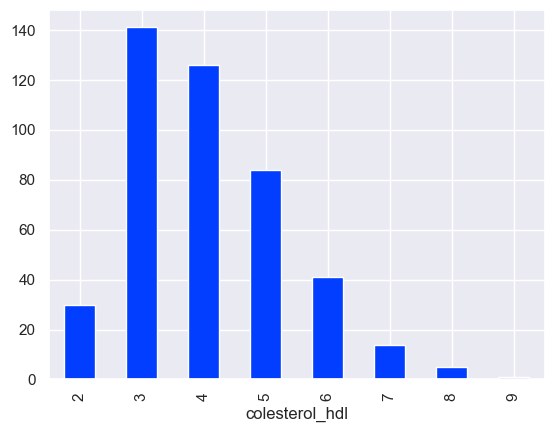

In [5]:
df["colesterol_hdl"].value_counts().sort_index().plot(kind="bar")

In [6]:
df["colesterol_hdl_cat"] = pd.cut(
    df["colesterol_hdl"],
    bins=[2, 4, 6, 10],
    labels=["2-3", "4-5", "6+"],
    right=False,
)

df["colesterol_hdl_cat"].value_counts().sort_index()

colesterol_hdl_cat
2-3    171
4-5    210
6+      61
Name: count, dtype: int64

In [7]:
df = df.drop(columns=["colesterol_hdl"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   idade               442 non-null    int8    
 1   sexo                442 non-null    int8    
 2   imc                 442 non-null    float32 
 3   pressao_media       442 non-null    float32 
 4   colesterol_total    442 non-null    int16   
 5   ldl                 442 non-null    float32 
 6   hdl                 442 non-null    float32 
 7   triglicerides       442 non-null    float32 
 8   glicose             442 non-null    int8    
 9   target              442 non-null    int16   
 10  colesterol_hdl_cat  442 non-null    category
dtypes: category(1), float32(5), int16(2), int8(3)
memory usage: 12.3 KB


In [8]:
df["sexo"] = df["sexo"].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   idade               442 non-null    int8    
 1   sexo                442 non-null    category
 2   imc                 442 non-null    float32 
 3   pressao_media       442 non-null    float32 
 4   colesterol_total    442 non-null    int16   
 5   ldl                 442 non-null    float32 
 6   hdl                 442 non-null    float32 
 7   triglicerides       442 non-null    float32 
 8   glicose             442 non-null    int8    
 9   target              442 non-null    int16   
 10  colesterol_hdl_cat  442 non-null    category
dtypes: category(2), float32(5), int16(2), int8(2)
memory usage: 12.4 KB


In [9]:
df.to_parquet(DADOS_CATEGORIZADOS, index=False)

In [10]:
colunas_power_transform = ["imc", "ldl", "hdl", "colesterol_total"]

coluna_target = ["target"]

coluna_ordinal_encoder = ["colesterol_hdl_cat"]

coluna_one_hot_encoder = ["sexo"]

colunas_standard_scaler = [
    coluna
    for coluna in df.columns
    if coluna not in colunas_power_transform + coluna_target + coluna_ordinal_encoder + coluna_one_hot_encoder
]

colunas_standard_scaler

['idade', 'pressao_media', 'triglicerides', 'glicose']

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

In [11]:
categorias_ordinal_encoder = [
    ["2-3", "4-5", "6+"],
]

In [12]:
X = df.drop(columns="target")
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html

In [13]:
preprocessamento = ColumnTransformer(
    [
        ("power_transform", PowerTransformer(method="box-cox"), colunas_power_transform),
        ("standard_scaler", StandardScaler(), colunas_standard_scaler),
        ("ordinal_encoder", OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="if_binary"), coluna_one_hot_encoder),
    ]
)

In [14]:
pipeline = Pipeline([
    ("preprocessor", preprocessamento),
    ("reg", LinearRegression())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('power_transform',
                                                  PowerTransformer(method='box-cox'),
                                                  ['imc', 'ldl', 'hdl',
                                                   'colesterol_total']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['idade', 'pressao_media',
                                                   'triglicerides',
                                                   'glicose']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['2-3',
                                                                              '4-5',
                                                                              '6+']]),
                                                  ['colesterol_hdl_cat']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sexo'])])),
                ('reg', LinearRegression())])

In [15]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('power_transform',
                                                  PowerTransformer(method='box-cox'),
                                                  ['imc', 'ldl', 'hdl',
                                                   'colesterol_total']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['idade', 'pressao_media',
                                                   'triglicerides',
                                                   'glicose']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['2-3',
                                                                              '4-5',
                                                                              '6+']]),
                                                  ['colesterol_hdl_cat']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sexo'])])),
                ('reg', LinearRegression())])

In [16]:
pipeline.named_steps

{'preprocessor': ColumnTransformer(transformers=[('power_transform',
                                  PowerTransformer(method='box-cox'),
                                  ['imc', 'ldl', 'hdl', 'colesterol_total']),
                                 ('standard_scaler', StandardScaler(),
                                  ['idade', 'pressao_media', 'triglicerides',
                                   'glicose']),
                                 ('ordinal_encoder',
                                  OrdinalEncoder(categories=[['2-3', '4-5',
                                                              '6+']]),
                                  ['colesterol_hdl_cat']),
                                 ('one_hot_encoder',
                                  OneHotEncoder(drop='if_binary'), ['sexo'])]),
 'reg': LinearRegression()}

In [17]:
pipeline["reg"].coef_

array([ 24.60264083,  16.77191904,  -0.14753084, -33.22254628,
         0.90968743,  16.86986256,  31.41955402,   3.20234273,
        13.18549218, -24.69113706])

In [18]:
pipeline["reg"].intercept_

np.float64(155.41186340867097)

In [19]:
pipeline["preprocessor"].feature_names_in_

array(['idade', 'sexo', 'imc', 'pressao_media', 'colesterol_total', 'ldl',
       'hdl', 'triglicerides', 'glicose', 'colesterol_hdl_cat'],
      dtype=object)

In [20]:
pipeline["preprocessor"].get_feature_names_out()

array(['power_transform__imc', 'power_transform__ldl',
       'power_transform__hdl', 'power_transform__colesterol_total',
       'standard_scaler__idade', 'standard_scaler__pressao_media',
       'standard_scaler__triglicerides', 'standard_scaler__glicose',
       'ordinal_encoder__colesterol_hdl_cat', 'one_hot_encoder__sexo_2'],
      dtype=object)

In [21]:
coefs = dataframe_coeficientes(
    pipeline["reg"].coef_,
    pipeline["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
power_transform__colesterol_total,-33.222546
one_hot_encoder__sexo_2,-24.691137
power_transform__hdl,-0.147531
standard_scaler__idade,0.909687
standard_scaler__glicose,3.202343
ordinal_encoder__colesterol_hdl_cat,13.185492
power_transform__ldl,16.771919
standard_scaler__pressao_media,16.869863
power_transform__imc,24.602641
standard_scaler__triglicerides,31.419554


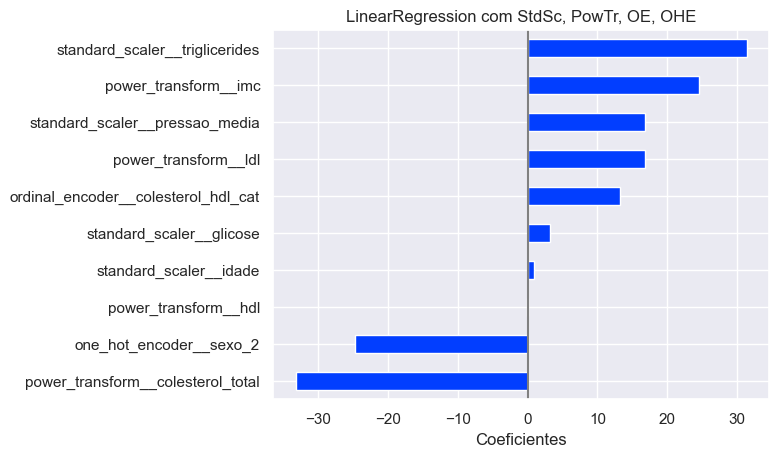

In [22]:
plot_coeficientes(coefs, "LinearRegression com StdSc, PowTr, OE, OHE")

In [23]:
pipeline["preprocessor"].transform(X)[:5]

array([[ 1.24025619, -0.68240219, -0.92674726, -0.9118759 ,  0.7917738 ,
         0.42754114,  0.39135751, -0.40439731,  1.        ,  1.        ],
       [-1.21033001, -0.32398331,  1.49262774, -0.09883377, -0.0718379 ,
        -0.56832451, -1.45617545, -1.94766474,  0.        ,  0.        ],
       [ 0.94915891, -0.66767144, -0.61961627, -0.94510597,  1.81240582,
        -0.14152497,  0.03444809, -0.57587147,  1.        ,  1.        ],
       [-0.1769703 ,  0.59447324, -0.71922678,  0.33144897, -1.95608163,
        -0.78172433,  0.44956997, -0.23292314,  1.        ,  0.        ],
       [-0.79061753,  0.40887439,  0.32957292,  0.16237147,  0.08518241,
         0.42754114, -0.69521284, -1.00455689,  1.        ,  0.        ]])

In [24]:
X["colesterol_hdl_cat"].head()

0    4-5
1    2-3
2    4-5
3    4-5
4    4-5
Name: colesterol_hdl_cat, dtype: category
Categories (3, object): ['2-3' < '4-5' < '6+']

In [25]:
pipeline["preprocessor"]["ordinal_encoder"].transform(X[["colesterol_hdl_cat"]])[:5]

array([[1.],
       [0.],
       [1.],
       [1.],
       [1.]])

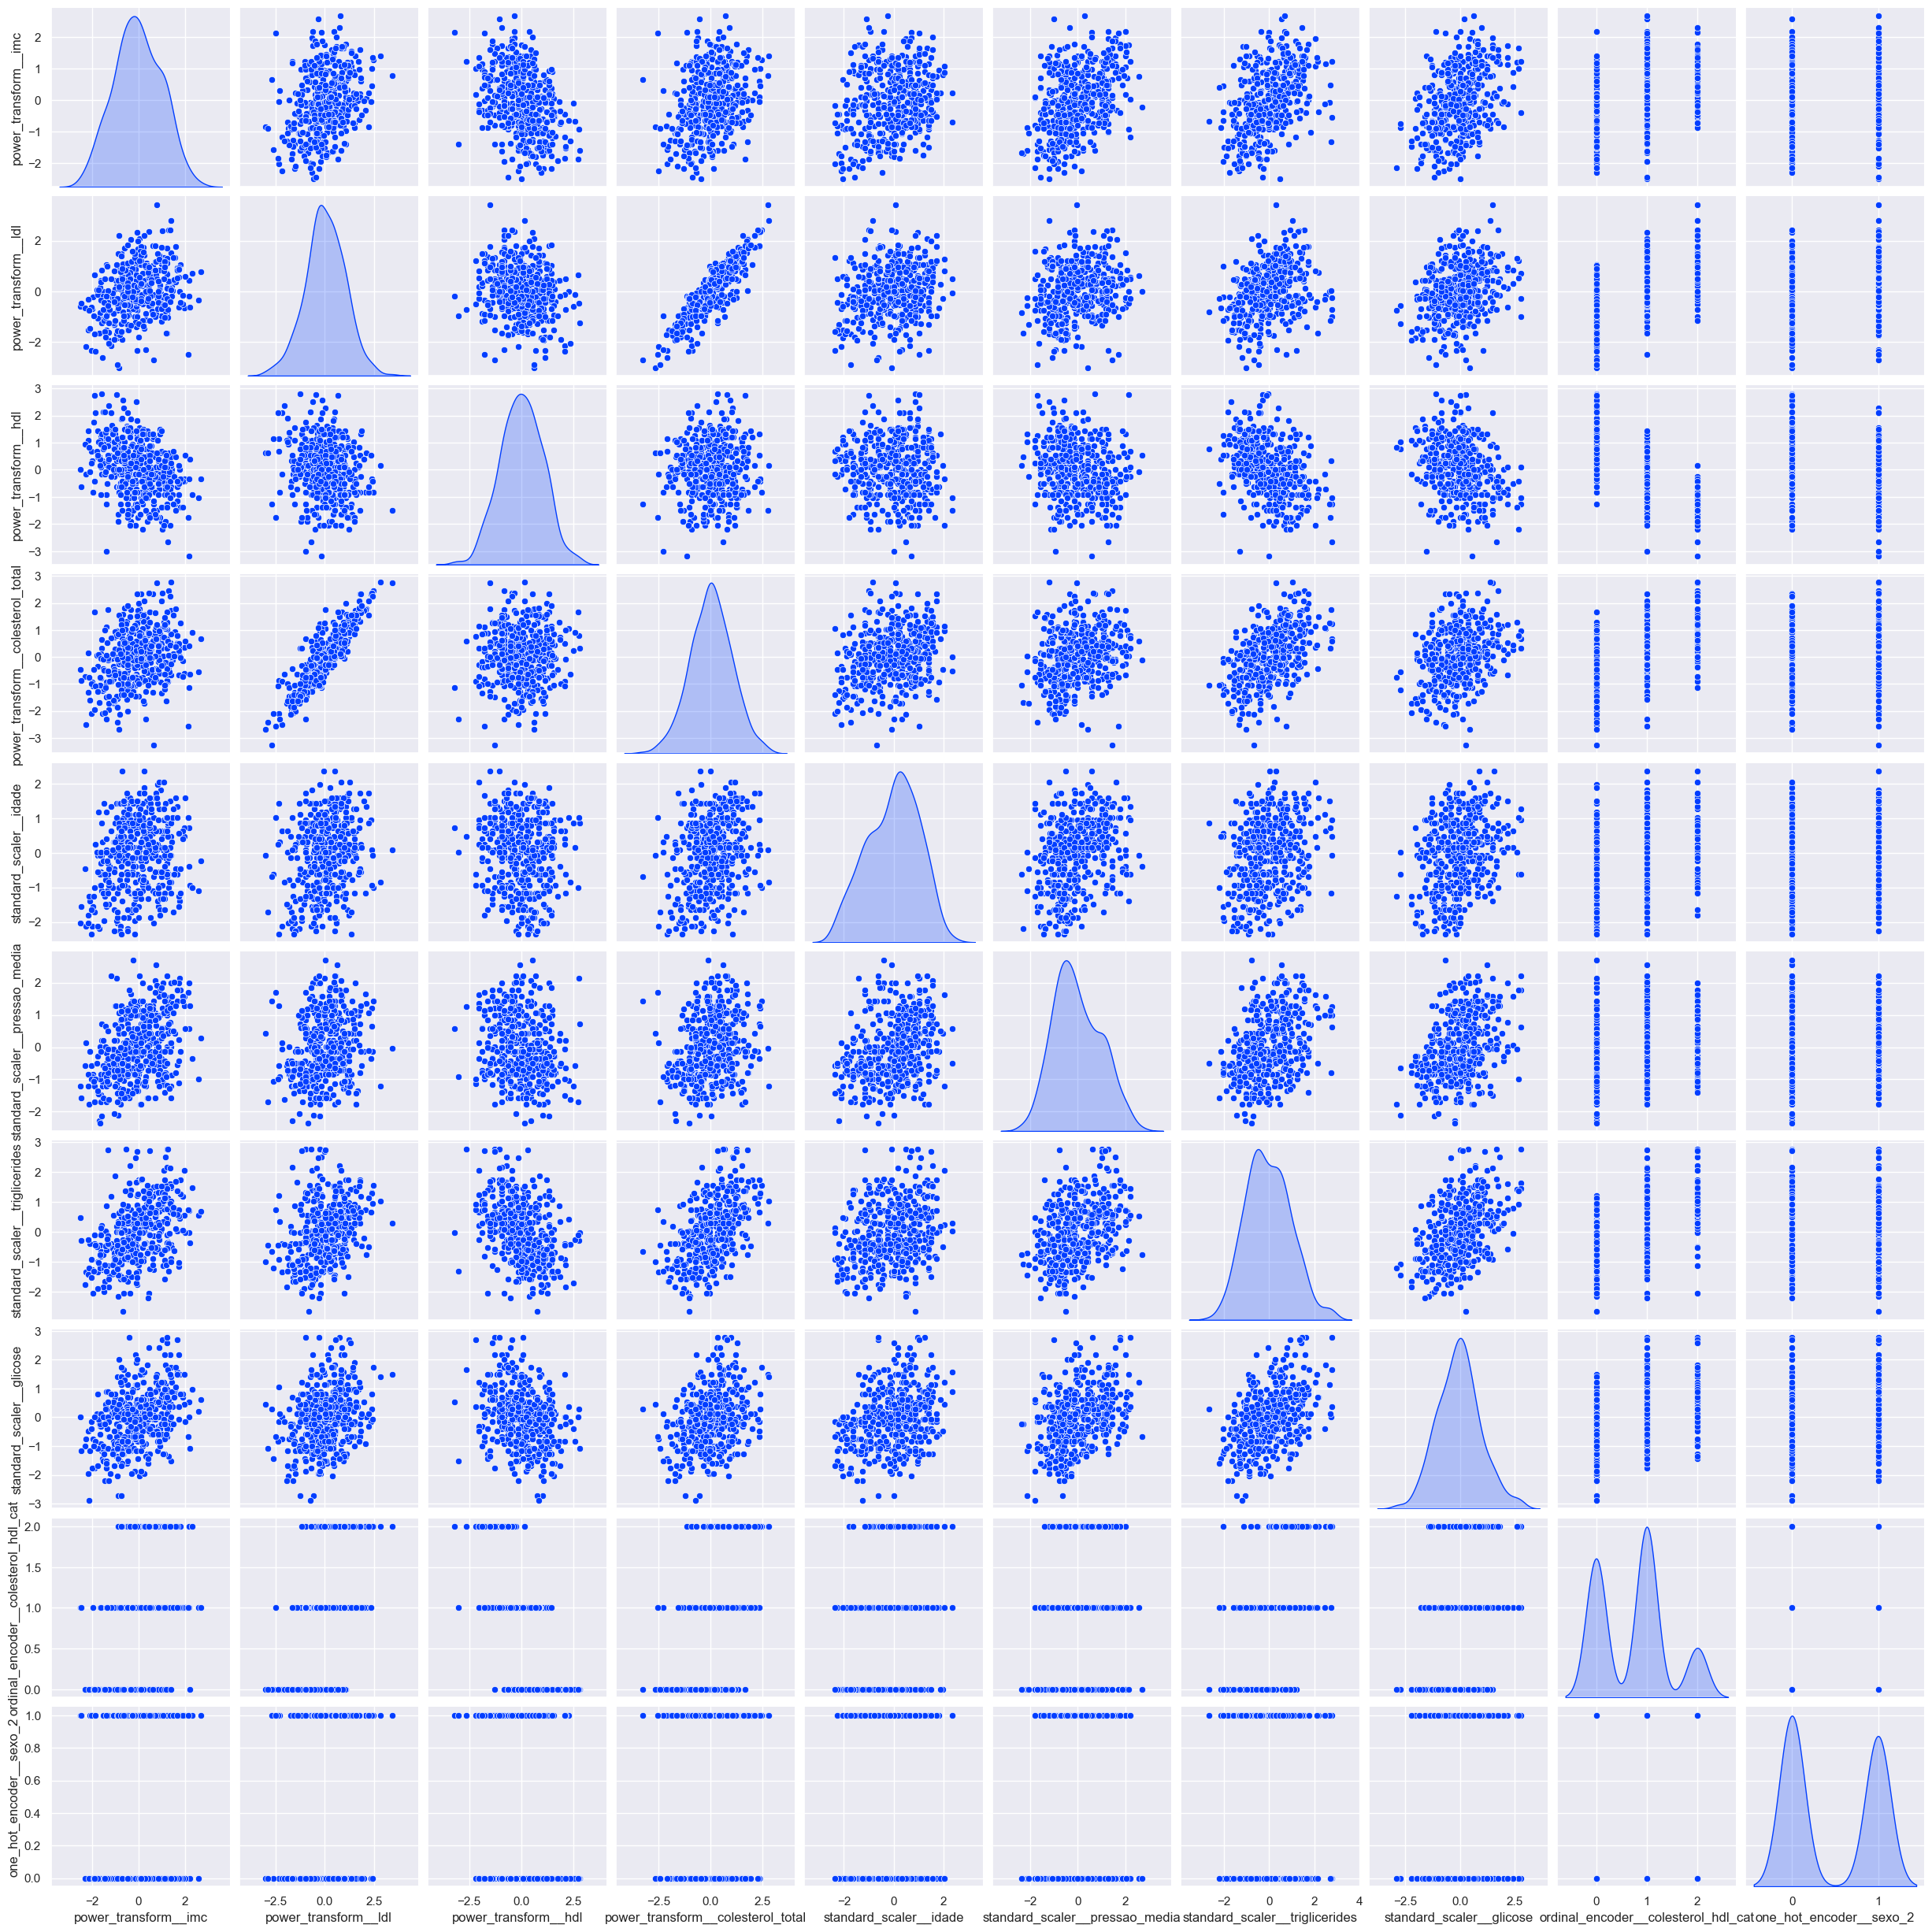

In [26]:
X_scaled = pipeline["preprocessor"].transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=pipeline["preprocessor"].get_feature_names_out())

sns.pairplot(X_scaled, diag_kind="kde")

In [27]:
y_pred = pipeline.predict(X_test)

In [28]:
mean_absolute_error(y_test, y_pred)

np.float64(43.64435051851416)

In [29]:
mean_squared_error(y_test, y_pred)

np.float64(2957.3942546592366)

In [30]:
root_mean_squared_error(y_test, y_pred)

np.float64(54.38192948635821)

In [31]:
r2_score(y_test, y_pred)

0.4418064270266966

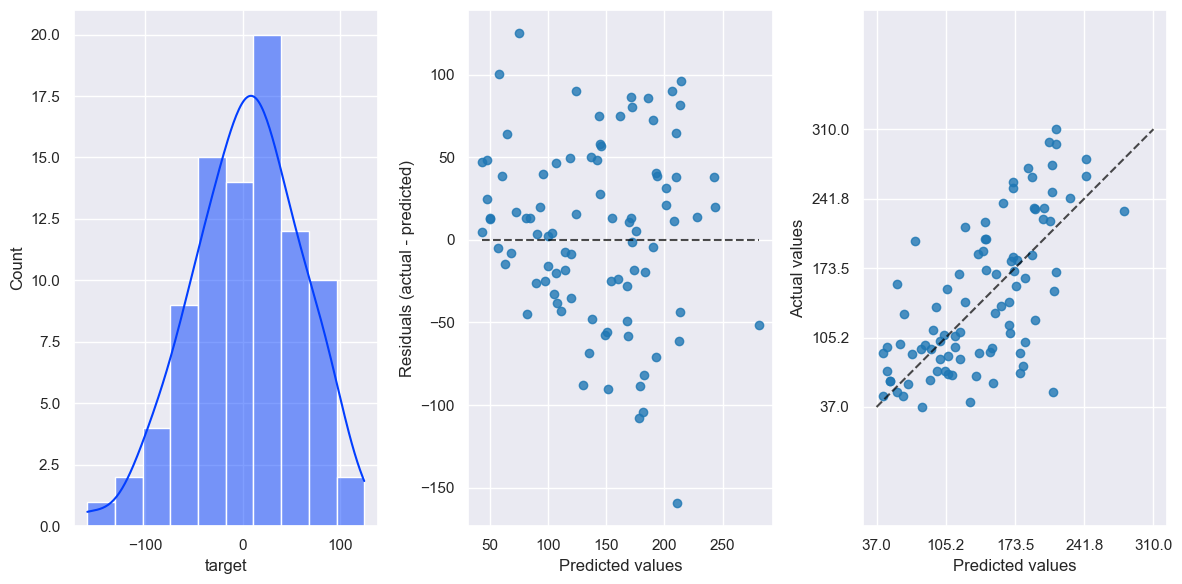

In [32]:
plot_residuos(y_test, y_pred)